1. Возьмите одну из предобученных моделей torchvision (например, resnet18, efficientnet_b0, mobilenet_v3_small).
2. Замените последний слой на количество классов вашего датасета.
3. Дообучите модель на train, проверьте качество на val.
4. Визуализируйте процесс обучения (loss/accuracy).

Epoch 1/15 | Train loss: 1.2123 | Test loss: 3.3146 | Train acc: 0.5444 | Test acc: 0.5567
Epoch 2/15 | Train loss: 0.2190 | Test loss: 3.4483 | Train acc: 0.9278 | Test acc: 0.5417
Epoch 3/15 | Train loss: 0.1294 | Test loss: 4.7845 | Train acc: 0.9556 | Test acc: 0.5900
Epoch 4/15 | Train loss: 0.1323 | Test loss: 3.0175 | Train acc: 0.9500 | Test acc: 0.5567
Epoch 5/15 | Train loss: 0.1423 | Test loss: 1.5146 | Train acc: 0.9556 | Test acc: 0.7050
Epoch 6/15 | Train loss: 0.1621 | Test loss: 1.0237 | Train acc: 0.9611 | Test acc: 0.7683
Epoch 7/15 | Train loss: 0.0560 | Test loss: 1.7294 | Train acc: 0.9889 | Test acc: 0.6233
Epoch 8/15 | Train loss: 0.0605 | Test loss: 1.1404 | Train acc: 0.9889 | Test acc: 0.7000
Epoch 9/15 | Train loss: 0.0506 | Test loss: 0.7973 | Train acc: 0.9889 | Test acc: 0.7717
Epoch 10/15 | Train loss: 0.1124 | Test loss: 0.6493 | Train acc: 0.9833 | Test acc: 0.8000
Epoch 11/15 | Train loss: 0.0286 | Test loss: 0.5405 | Train acc: 0.9889 | Test acc: 0.84

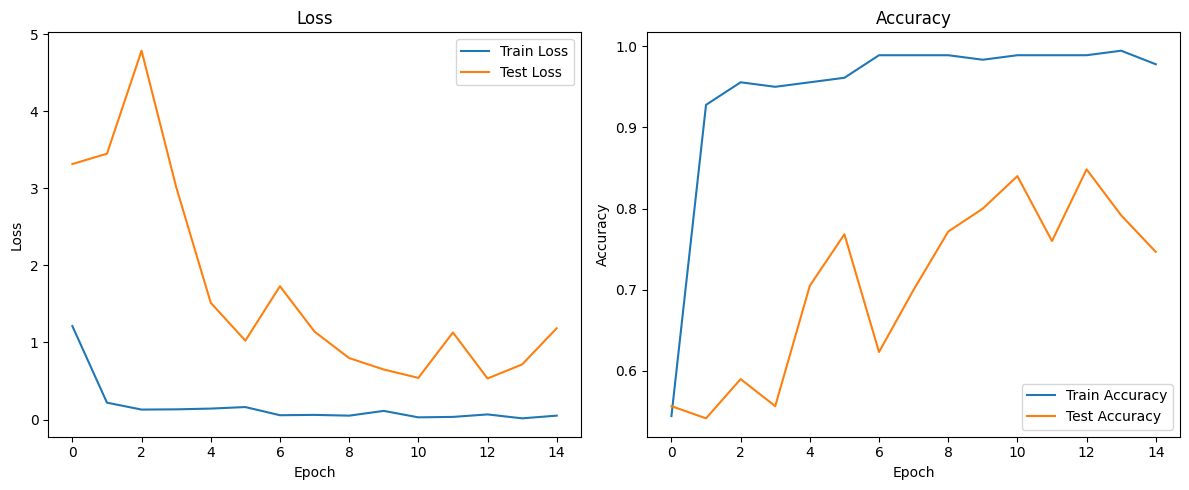

In [4]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms, models
from torch.utils.data import DataLoader
from datasets import CustomImageDataset

# Параметры 
batch_size = 32
num_epochs = 15
lr = 1e-3
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

# Аугментации и загрузка
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_dataset = CustomImageDataset('data/train', transform=train_transform)
test_dataset = CustomImageDataset('data/test', transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

num_classes = len(train_dataset.get_class_names())

# Модель
model = models.resnet18(weights='IMAGENET1K_V1')
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
model.to(device)

# Оптимизатор и функция потерь
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = torch.nn.CrossEntropyLoss()

train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

# Цикл обучения
for epoch in range(num_epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = loss_fn(out, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        preds = out.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)

    train_loss = total_loss / total
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    #Тестирование
    model.eval()
    test_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = loss_fn(out, y)
            test_loss += loss.item() * x.size(0)
            preds = out.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)

    test_loss /= total
    test_acc = correct / total
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)
    print(f"Epoch {epoch+1}/{num_epochs} | Train loss: {train_loss:.4f} | Test loss: {test_loss:.4f} | Train acc: {train_acc:.4f} | Test acc: {test_acc:.4f}")

# Визуализация
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()